<a href="https://colab.research.google.com/github/BrionyMeng/Colab-Temp/blob/main/PartII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part II - Layer Criticality

In this part of the assignment, we will focus on reproducing an intriguing phenomenon of deep networks, known as *layer criticality*, first reported by [Zhang et al. (2019)](https://openreview.net/forum?id=ryg1P4Sh2E).

The authors explore whether every layer of a discriminative deep network contributes equally to the performance of the learned classifier. Strikingly, it was observed that for some layers, the value of the corresponding parameters can be reset to initialization without severly affecting performance of the resulting model.

In practice, starting from a trained network and the initialization checkpoint that was used for training, you will reproduce the main result of Zhang et al., for a pre-trained ResNet18 which was produced using the code from Part I of this assignment.

## Introduction

Let $\theta^t = (\theta_1^t, \ldots, \theta_L^t)$ denote the parameters of a $L$-layer network at epoch $t$, with $\theta_\ell^t$ representing the parameters of the $\ell$-th layer. Let $t = T$ denote the final epoch of training. Consider now $\theta^0 = \theta^t_{|t = 0}$ &mdash; corresponding to the parameters of the same network at the specific initialization that was used for training.

Let $\mathcal{L}(\theta^t, \mathcal{D}) := \mathbb{E}_{B_i \sim \mathcal{D}}{[}\mathcal{L}(B_i, \theta^t){]}$ denote the average loss of the network with parameters $\theta^t$ over mini-batches $B_i$ sampled from a finite dataset $\mathcal{D} = \{(\mathbf{x}_n, y_n) \}_{n=1}^N$.

To study the criticality of each layer $\ell = 1, \ldots, L$ for performance of the network, the parameter $\theta^T = (\theta_1^T, \ldots, \theta_\ell^T, \ldots, \theta_L^T)$ is modified by setting $\theta_\ell^T = \theta_\ell^t$, for $t < T$.

Then, the relative drop in performance is computed as:
$$ drop = \big(\mathcal{L}(\theta^T) - \mathcal{L}(\theta^T_{|\theta_\ell^T = \theta_\ell^t}) \big) \big/ \mathcal{L}(\theta^T),$$
where the dependency of $\mathcal{L}$ on $\mathcal{D}$ has been omitted to simplify notation.

Given a list of checkpoint epochs $\{t_1 = 0, \ldots, t_s\}$, the methodology proposed by Zhang et al. consists in iterating through the layers of a trained network $(t = T)$ and compute the drop in performance when a layer $\ell$ is reset to its value at initialization, keeping all other layers fixed at their trained state.

In this assigment, we will consider two choices of $\mathcal{L}$, namely the cross-entropy loss and the 0/1 loss (accuracy). Finally, we will evaluate both losses on the train and test split of CIFAR-10.

## Getting started

In order to solve this assignment, you will need to [download the checkpoints](https://kth-my.sharepoint.com/:f:/g/personal/mgamba_ug_kth_se/EveGFRgj1zFAnoTtNVcbzecB37DsSi9AU8FeAGCx9R918g?e=VlfAUj) of a pretrained ResNet18 following the model definition of Part I. As previsouly noted, such model is a thinner version of ResNet v1 ([He et al., 2015](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html)), with fewer parameters to limit the computational requirements for this exercise. While the results reproduced in this assignment generalize to other datasets, we will use CIFAR-10 for simplicity ([Krizhevsky and Hinton, 2009](https://www.cs.toronto.edu/~kriz/cifar.html)).

Note: it is a good idea to verify the integrity of the downloaded zip archive by matching its `sha256` hash with the one provided at the download link. Afterwards, extract all files from the archive and take note of the path where they are stored.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.core import freeze, unfreeze, FrozenDict
from flax import traverse_util
import optax

import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import PIL.Image

from typing import Any, Callable, Sequence, Tuple, Dict
from functools import partial
import random
import os

import matplotlib.pyplot as plt
from IPython.display import Image, Markdown, display
import seaborn as sns

In [9]:
os.environ['JAX_PLATFORM_NAME'] = 'gpu'
# If running the notebook fails with OOM errors, please consider uncommenting the following line.
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
# If the notebook is failing at the very beginning with OOM error, uncomment the following line,
# and tune the amout of preallocated memory according to your system.
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.80'
"""
==============================
TODO: Configuration required.
==============================
Edit below to set your path to CIFAR-10, as well as the target directory for
loading checkpoints, and the path to the pre-trained model `resnet18_99.pickle`.
The pre-trained model is provided as part of this assignment, together with
checkpoints of several training epochs and initialization.

We will assume the naming convention of models trained using the code from part
I of this assignment. For example, `resnet18_EPOCH.pickle` will denote a
resnet18 model checkpoint taken at training epoch EPOCH.
"""
data_dir = "/content/drive/My Drive/DD2412-Practicals/P3 - Memorization/data" # path to cifar-10-batches-py
checkpoints_dir = "/content/drive/My Drive/DD2412-Practicals/P3 - Memorization/checkpoints"
metrics_file_dir = "/content/drive/My Drive/DD2412-Practicals/P3 - Memorization/metrics.json"
converged_model_fname = "/content/drive/My Drive/DD2412-Practicals/P3 - Memorization/checkpoints/resnet18_99.pickle" # path to converged model checkpoint
assert os.path.exists(converged_model_fname),\
    "The path you provided does not exists!"


In [10]:
# Useful hyperparameters
seed = 42
enable_batch_norm = False
batch_size = 128

cifar10_mean = (0.4919, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
num_classes = 10

"""
==============================
TODO: Configuration required.
==============================
Set the list of checkpoint epochs that will be used for the layer
reinitialization experiments.
The epochs should be picked by inspecting the checkpoint filenames of the
provided pre-trained model.

Keep in mind that training epochs are zero-indexed, and that a model
initialization is saved using the special keyword 'init'.

Your list of epochs should at least include checkpoints "init", and "0".
"""
epochs = ["init", "0", "20", "40","60", "80", "99"]
# dictionary of epoch: checkpoint filename
checkpoint_fnames = {
    str(epoch): os.path.join(checkpoints_dir, f"resnet18_{epoch}.pickle") for epoch in epochs }

In [11]:
# Data loading utilities
def numpy_collate(batch):
    """Collate batch into a single numpy.ndarray"""
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


class NumpyLoader(torch.utils.data.DataLoader):
    """Numpy dataloader subclassing pytorch's data loader"""
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)


# Transforms
class ArrayNormalize(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def __call__(self, arr: np.ndarray) -> np.ndarray:
        assert isinstance(arr, np.ndarray), "Input should be ndarray, got {}.".format(type(arr))
        assert arr.ndim >= 3, "Expected array to be image of size (*, H, W, C). Got {}.".format(arr.shape)

        dtype = arr.dtype
        mean = np.asarray(self.mean, dtype=dtype)
        std = np.asarray(self.std, dtype=dtype)
        if (std == 0).any():
            raise ValueError("std evaluated to zero after conversion to {}".format(dtype))
        if mean.ndim == 1:
            mean = mean.reshape(1, 1, -1)
        if std.ndim == 1:
            std = std.reshape(1, 1, -1)
        arr -= mean
        arr /= std
        return arr


class ToArray(torch.nn.Module):
    dtype = np.float32

    def __call__(self, x):
        assert isinstance(x, PIL.Image.Image)
        x = np.asarray(x, dtype=self.dtype)
        x /= 255.0
        return x

transform = transforms.Compose([
    ToArray(),
    ArrayNormalize(cifar10_mean, cifar10_std)])

In [12]:
import shutil

# Remove the data_dir
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
    print(f"Removed directory: {data_dir}")
else:
    print(f"Directory not found: {data_dir}")

Removed directory: /content/drive/My Drive/DD2412-Practicals/P3 - Memorization/data


In [13]:
# load CIFAR-10
cifar10_train = CIFAR10(data_dir, download=True, transform=transform, train=True)
cifar10_test = CIFAR10(data_dir, download=True, transform=transform, train=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 41563344.44it/s]


Extracting /content/drive/My Drive/DD2412-Practicals/P3 - Memorization/data/cifar-10-python.tar.gz to /content/drive/My Drive/DD2412-Practicals/P3 - Memorization/data
Files already downloaded and verified


In [14]:
# set seed for reproducibilty
torch.manual_seed(seed)
random.seed(seed)
# instantiate data loaders
train_loader = NumpyLoader(cifar10_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_loader = NumpyLoader(cifar10_test, batch_size=2*batch_size, num_workers=0)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## ResNet model definition

In [15]:
ModuleDef = Any

class ResNetBlock(nn.Module):
    """ResNet basic block"""
    filters: int
    conv: ModuleDef
    norm: ModuleDef
    act: Callable
    strides: Tuple[int,int] = (1,1)

    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (3,3), self.strides)(x)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3,3))(y)
        if self.norm is not None:
            y = self.norm(scale_init=nn.initializers.zeros)(y)

        if residual.shape != y.shape:
            residual = self.conv(self.filters, (1,1), self.strides, name='conv_proj')(residual)
            if self.norm is not None:
                residual = self.norm(name='norm_proj')(residual)

        return self.act(residual + y)


class BottleneckBlock(nn.Module):
    """Bottleneck residual block"""
    filters: int
    conv: ModuleDef
    norm: ModuleDef
    act: Callable
    strides: Tuple[int, int] = (1, 1)

    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (1,1))(x)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3, 3), self.strides)(y)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters * 4, (1,1))(y)
        if self.norm is not None:
            y = self.norm(scale_init=nn.initializers.zeros)(y)

        if residual.shape != y.shape:
            residual = self.conv(self.filters * 4, (1, 1), self.strides, name='conv_proj')(residual)
            if self.norm is not None:
                residual = self.norm(name='norm_proj')(residual)

        return self.act(residual + y)


class ResNet(nn.Module):
    """ResNet v1"""
    stage_sizes: Sequence[int]
    block_cls: ModuleDef
    num_classes: int = 10 # adapted to CIFAR-10
    num_filters: int = 16 # reduced number of filters to decrease training time
    dtype: Any = jnp.float32
    act: Callable = nn.relu

    def setup(self, enable_batch_norm=False):
        self.enable_batch_norm = enable_batch_norm

    @nn.compact
    def __call__(self, x, train: bool = True):
        conv = partial(nn.Conv, use_bias = not self.enable_batch_norm, dtype = self.dtype)
        if self.enable_batch_norm:
            norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=self.dtype)
        else:
            norm = None

        x = conv(self.num_filters, (3,3), (1,1),
                 padding='SAME', name='conv_init')(x)
        if self.enable_batch_norm:
            x = norm(name='bn_init')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2), padding='SAME')
        for i, block_size in enumerate(self.stage_sizes):
            for j in range(block_size):
                strides = (2, 2) if i > 0 and j == 0 else (1, 1)
                x = self.block_cls(self.num_filters * 2 ** i,
                                   strides=strides,
                                   conv=conv,
                                   norm=norm,
                                   act=self.act)(x)
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
        x = jnp.asarray(x, self.dtype)
        return x

ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)

## Evaluation utilities

In [16]:
def compute_metrics(logits, labels):
    """Given the model predictions @logits and ground-truth @labels compute
       loss and accuracy.
    ==============================
    TODO: Implementation required.
    ==============================
    Copy here your implementation of @compute_metrics from part I.
    """
    probs = jax.nn.softmax(logits)

    labels_one_hot = jax.nn.one_hot(labels, logits.shape[-1])
    log_probs = jax.numpy.log(probs + 1e-10)
    loss = -jax.numpy.mean(jax.numpy.sum(labels_one_hot * log_probs, axis=-1))

    predicted_class = jax.numpy.argmax(logits, axis=-1)
    accuracy = jax.numpy.mean(predicted_class == labels)

    metrics = {
        'accuracy': accuracy,
        'loss': loss
    }

    return metrics


@jax.jit
def eval_step(params, batch):
    """Evaluate ResNet18 on batch using params.
    """
    logits = ResNet18().apply({'params': params}, batch['image'], train=False)
    return compute_metrics(logits=logits, labels=batch['label'])


def eval_model(epoch, params, data_loader):
    """Evaluate model using data loader
    """
    batch_metrics = []
    for input, target in data_loader:
        batch = {
            'image': input,
            'label': target,
        }

        metrics = eval_step(params, batch)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    split = "train" if data_loader.dataset.train else "test"
    print("epoch: {}, {} loss: {}, {} accuracy: {}".format(
            epoch, split, epoch_metrics_np['loss'], split, epoch_metrics_np['accuracy']))
    return epoch_metrics_np

## Utilities for working with parameter dictionaries

In [17]:
def load_state_dict(checkpoint_fname):
    """Load state dictionary from file.
    """
    state_dict = torch.load(checkpoint_fname)
    return state_dict


def load_checkpoint(rng, checkpoint_fname):
    """Restore saved checkpoint
    """
    net = ResNet18(num_classes=num_classes)
    params = net.init(rng, jnp.ones((1, 32, 32, 3)))['params']
    state_dict = load_state_dict(checkpoint_fname)

    params = unfreeze(params)
    params = state_dict["state"]
    params = freeze(params)

    return params


def flatten_dict(d: Dict) -> Dict:
    """Traverse a nested dictionary @d and return a flattened version of it.
    """
    return {'/'.join(k): v for k, v in traverse_util.flatten_dict(d).items()}


def unflatten_dict(d: Dict) -> Dict:
    """Unflatten parameter dictionary @d back to a nested dictionary
    """
    return traverse_util.unflatten_dict({tuple(k.split('/')): v for k, v in d.items()})


def print_flat_params_dict(d: Dict) -> None:
    """Print flattened dictionary, together with the shape of all tensors it
       contains
    """
    print(jax.tree_map(jnp.shape, d))


def layers(params: FrozenDict) -> str:
    """Yield each layer of a parameter dictionary
    """
    def is_leaf(prefix, xs):
        return 'kernel' in list(xs.keys())

    layer_ids = [ '/'.join(k) for k, _ in traverse_util.flatten_dict(unfreeze(params), is_leaf=is_leaf).items() ]
    for layer in layer_ids:
        yield layer


def num_layers(params: FrozenDict) -> int:
    """Return the number of layers in a parameter dictionary
    """
    return len(list(layers(params)))

In [18]:
def performance_drop(eval_metrics, metrics_converged):
    """Compute the performance drop of @eval_metrics relative to @metrics_converged

       ==============================
       TODO: Implementation required.
       ==============================
       For each metric in @eval_metrics, compute the relative decrease in performance
       from the corresponding metric in @metrics_converged.

       @return Dict: a dictionary {'accuracy': acc_drop, 'loss': loss_incr}
               where acc_drop is the relative drop in accuracy computed by this function
               and loss_incr is the relative loss increase.
    """

    acc_drop = (metrics_converged['accuracy'] - eval_metrics['accuracy']) / metrics_converged['accuracy']
    loss_incr = (eval_metrics['loss'] - metrics_converged['loss']) / metrics_converged['loss']

    perf_drop = {
        'accuracy': acc_drop,
        'loss': loss_incr
    }

    return perf_drop

test the `performance_drop` function

In [19]:
eval_metrics = {'accuracy': 60,
                'loss' : 7.33}
metrics_converged = {'accuracy': 99,
                'loss' : 5.02}
expected = {'accuracy': 0.3939393,
            'loss': 0.4601593}
output = performance_drop(eval_metrics, metrics_converged)
for v1,v2 in zip(output.values(),
                 expected.values()):
    np.testing.assert_almost_equal(v1,v2,)

In [20]:
def update_metrics(epoch, metrics, new_metrics, split):
    """Update the dictionary metrics[split] with the keys and values
       from @new_metrics. Return the updated dictionary.
    """
    for key in new_metrics:
        try:
            metrics[split][key][str(epoch)].append(new_metrics[key].item())
        except KeyError:
            metrics[split][key][str(epoch)] = [new_metrics[key].item()]
    return metrics

In [21]:
def reinit_layer(params: FrozenDict, params_init: FrozenDict, layer_id: str) -> FrozenDict:
    """
    ==============================
    TODO: Implementation required.
    ==============================
    Set @params at key @layer_id with the corresponding value from @params_init

    Hint: both weight and bias (if present) of layer @layer_id should be reinitialized
    Hint: the FrozenDict params needs to be unfrozen and flattened for you to operate upon
    Hint: the returned dictionary should be a FrozenDict

    @params: parameter dictionary of a trained model
    @params_init: parameter dictionary of the same model, at initialization
    @layer_id: dictionary key denoting the layer whose parameters are to be reinitialized.
               The key should be chosen by inspecting the flattened dict @params.

    @return modified_params
    """

    params_flat = flatten_dict(unfreeze(params))
    params_init_flat = flatten_dict(unfreeze(params_init))


    for key in params_flat.keys():
        if layer_id in key:
            params_flat[key] = params_init_flat[key]

    modified_params_hierarchical = unflatten_dict(params_flat)

    modified_params = freeze(modified_params_hierarchical)

    return modified_params

test the `reinit_layer` function:

In [22]:
rng = jax.random.PRNGKey(seed)
test_params = freeze(
    {"test_layer_0":{
        "bias": jnp.zeros(4),
        "kernel": jnp.zeros((1,4)),
        },
     "test_layer_1": {
        "Conv_0": {
            "bias": jnp.zeros(6),
            "kernel": jnp.zeros((4,6)),
        },
        "Conv_1": {
            "bias": jnp.zeros(8),
            "kernel": jnp.zeros((6,8)),
        }
        },
     "test_layer_2":{
        "kernel": jnp.zeros((8,4)),
        },
    })
test_params_init = freeze(
    {"test_layer_0":{
        "bias": jnp.ones(4),
        "kernel": jnp.ones((1,4)),
        },
     "test_layer_1": {
        "Conv_0": {
            "bias": jnp.ones(6),
            "kernel": jnp.ones((4,6)),
        },
        "Conv_1": {
            "bias": jnp.ones(8),
            "kernel": jnp.ones((6,8)),
        }
        },
     "test_layer_2":{
        "kernel": jnp.ones((8,4)),
        },
    })

test_params_flat = flatten_dict(test_params)
test_params_init_flat = flatten_dict(test_params_init)
layer_id = next(layers(test_params))
returned = reinit_layer(test_params,
                        test_params_init,
                        layer_id)
assert isinstance(returned,FrozenDict),\
    'the output of reinit_layer function should be of FrozenDict type'

returned_flat = flatten_dict(returned)
for layer in test_params_flat:
    if layer_id in layer:
        np.testing.assert_array_equal(
            returned_flat[layer],
            test_params_init_flat[layer])
    else:
        np.testing.assert_array_equal(
            returned_flat[layer],
            test_params_flat[layer])

In [23]:
def reinit_layers(epoch, metrics, metrics_converged, params, params_epoch, train_loader, test_loader):
    """
    Loop through the layers of the @params dictionary. For each layer,
    reinitialize the correponding entry in @params with that of @params_epoch

    Use @train_loader and @test_loader to evaluate the model resulting from
    modifying @params.

    Compute the drop in performance of the modified model from the converged model
    and store the result in @metrics using the key @epoch.
    """
    # loop through layers
    for l in layers(params):
        print("Reinitializing layer {}".format(l))
        params_reinit = reinit_layer(params, params_epoch, l)

        # eval network
        eval_metrics = eval_model(epoch, params_reinit, test_loader)
        train_metrics = eval_model(epoch, params_reinit, train_loader)
        del params_reinit

        # performance drop
        perf_drop_test = performance_drop(eval_metrics, metrics_converged['test'])
        perf_drop_train = performance_drop(train_metrics, metrics_converged['train'])

        # update metrics dictionary
        metrics = update_metrics(epoch, metrics, perf_drop_test, split='test')
        metrics = update_metrics(epoch, metrics, perf_drop_train, split='train')

    return metrics

## main function

In [24]:
import json

def reinit_network(checkpoint_fnames, converged_model_fname, train_loader, test_loader):
    """For each layer L and checkpoint C, reinitialize layer L to the parameters
       values at checkpoint C and compute the relative drop in validation
       performance.
    """
    # Load checkpoint of converged model
    rng = jax.random.PRNGKey(seed)
    params = load_checkpoint(rng, converged_model_fname)

    # Initialize results dictionary
    metrics = {
        'train': {
            'loss' : {},
            'accuracy': {},
        },
        'test': {
            'loss': {},
            'accuracy': {},
        },
    }

    # dictionary of train/eval metrics for converged model
    metrics_converged = {
        'train' : { },
        'test': { }
    }

    # compute performance of converged model
    print("Computing performance of converged model")
    metrics_converged['train'].update(
        eval_model(99, params, test_loader))
    metrics_converged['test'].update(
        eval_model(99, params, train_loader))

    # iterate through checkpoint fnames
    for epoch, checkpoint in checkpoint_fnames.items():
        params_epoch = load_checkpoint(rng, checkpoint)
        # iterate through layers
        metrics = reinit_layers(
            epoch, metrics, metrics_converged, params, params_epoch, train_loader, test_loader)
        del params_epoch

        with open(metrics_file_dir, 'w') as file:
          json.dump(metrics, file)



    return metrics

In [25]:
metrics = reinit_network(checkpoint_fnames, converged_model_fname, train_loader, test_loader)

Computing performance of converged model
epoch: 99, test loss: 0.5303783416748047, test accuracy: 0.829296886920929
epoch: 99, train loss: 0.29959598183631897, train accuracy: 0.8937299847602844
Reinitializing layer Dense_0
epoch: init, test loss: 0.7873477339744568, test accuracy: 0.755175769329071
epoch: init, train loss: 0.6586576104164124, train accuracy: 0.8060897588729858
Reinitializing layer ResNetBlock_0/Conv_0
epoch: init, test loss: 2.144293785095215, test accuracy: 0.3866210877895355
epoch: init, train loss: 2.1227738857269287, train accuracy: 0.3923277258872986
Reinitializing layer ResNetBlock_0/Conv_1
epoch: init, test loss: 1.1482367515563965, test accuracy: 0.6485351324081421
epoch: init, train loss: 0.9921799302101135, train accuracy: 0.6842548251152039
Reinitializing layer ResNetBlock_1/Conv_0
epoch: init, test loss: 1.5889921188354492, test accuracy: 0.524609386920929
epoch: init, train loss: 1.5204998254776, train accuracy: 0.5381810665130615
Reinitializing layer Res

## Criticality heatmaps

Finally, we visualize the performance drop of reinitializing each layer at a specified epoch as a heatmap. By observing the plots below, answer the following.

1. Which layers are most critical for performance?
2. Can you see stronger impact on cross-entropy loss or 0/1 loss (accuracy)?
3. If several layers can be reinitialized without considerable impact on performance, can you speculate on their role for training?

Please note that layers are sorted in the order they are stored as a `FrozenDict`, rather than in the way they appear in the network. This is reflected in the criticality heatmaps.

### train_loss

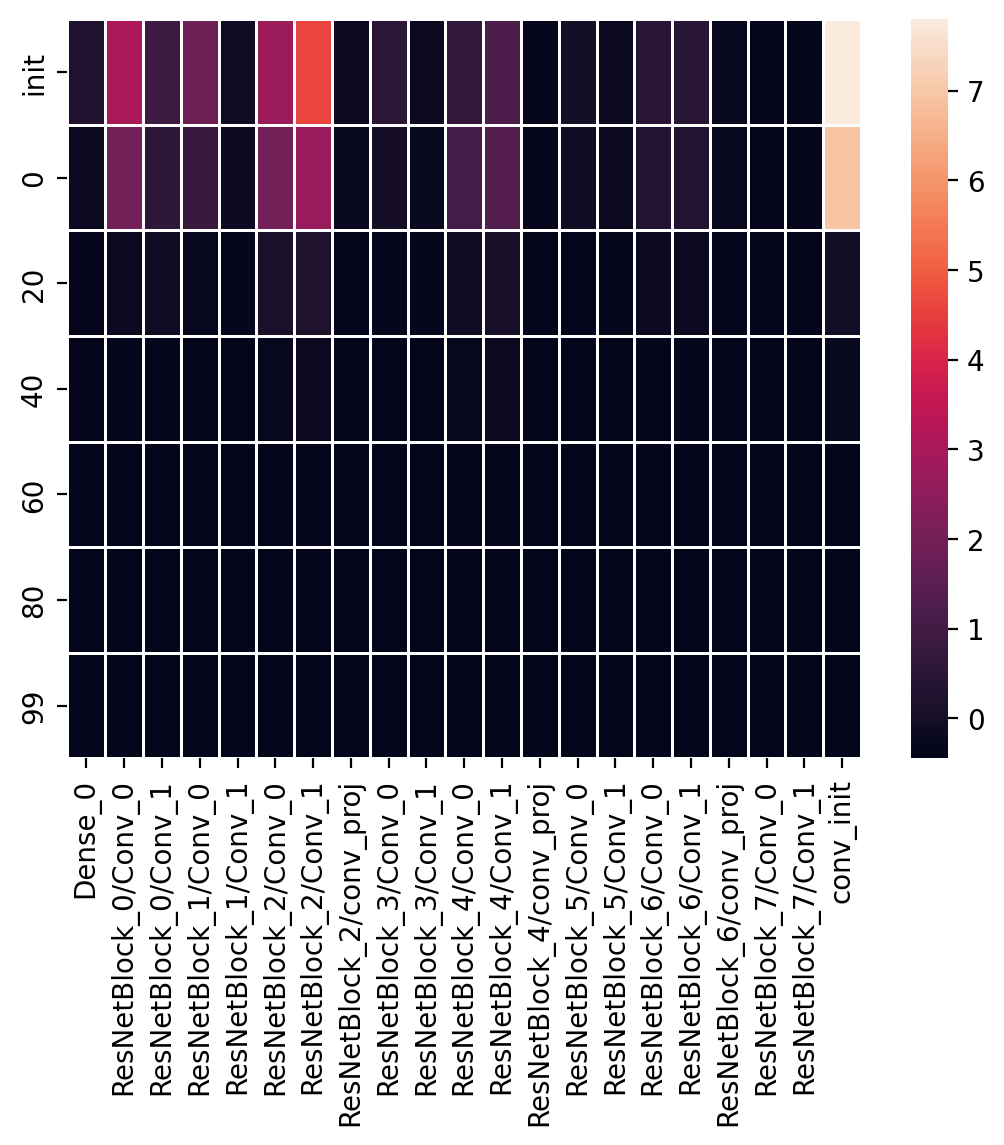

### train_accuracy

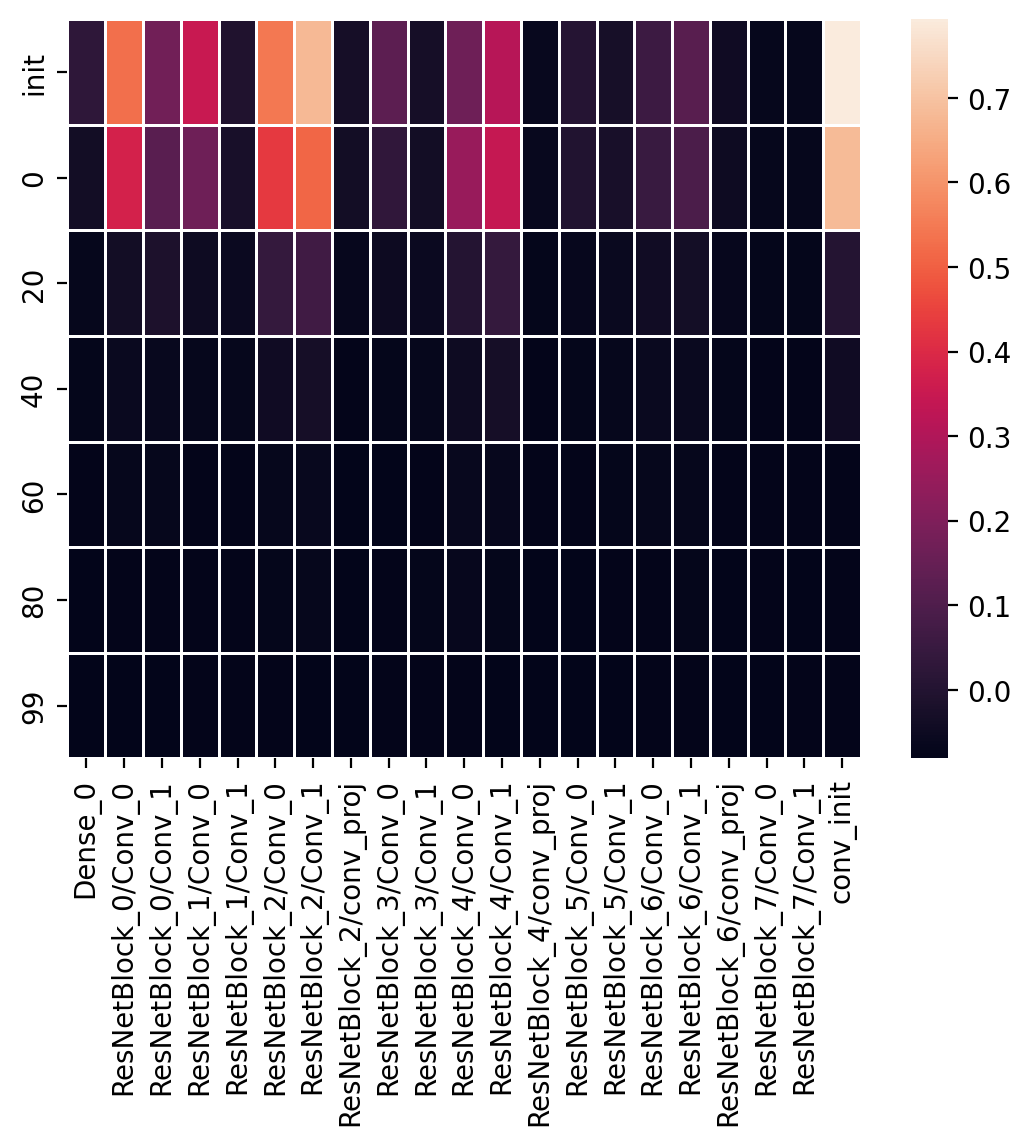

### test_loss

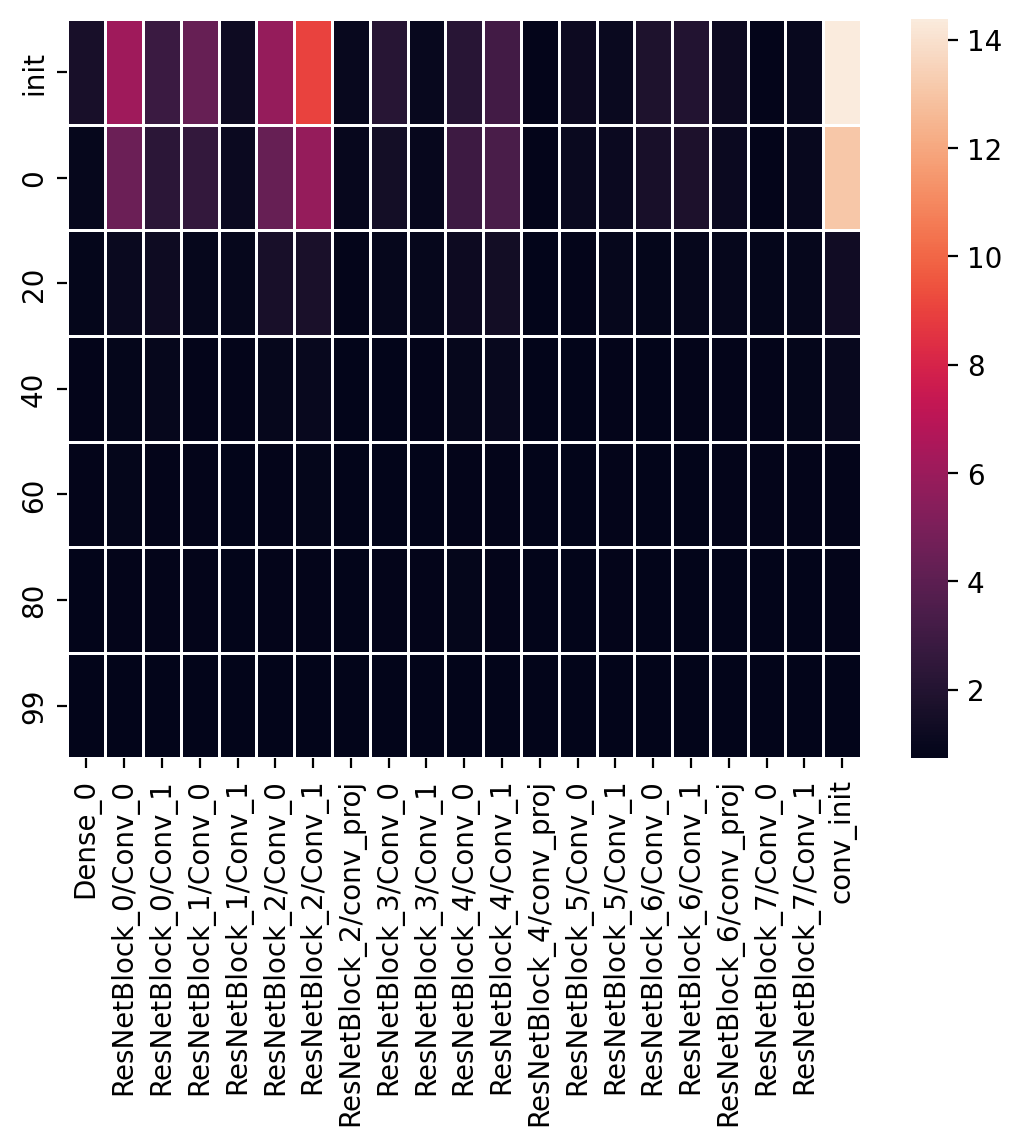

### test_accuracy

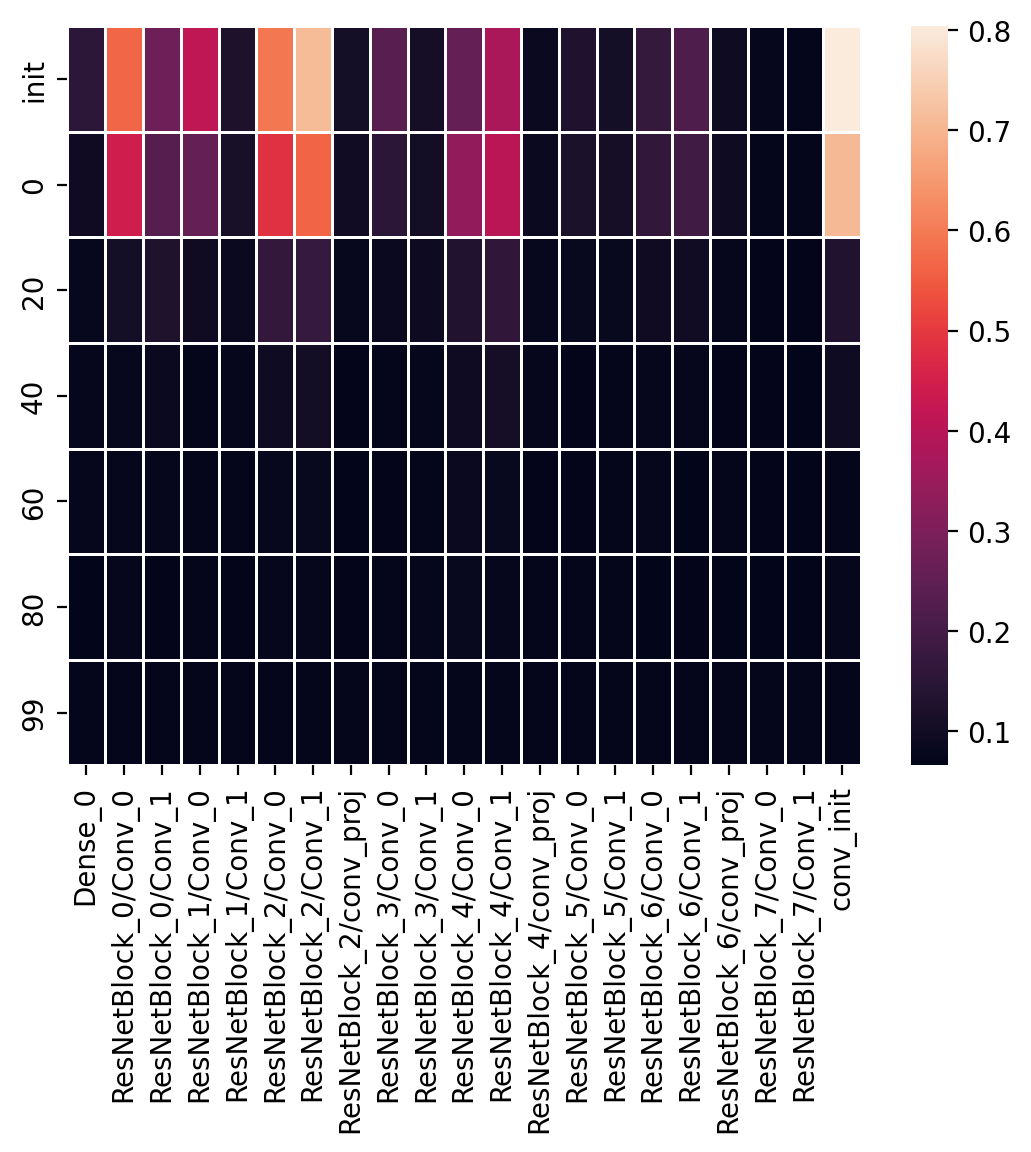

<Figure size 640x480 with 0 Axes>

In [26]:
# plot the results
def get_layer_names():
    params = load_checkpoint(jax.random.PRNGKey(seed), converged_model_fname)
    names = list(layers(params))
    return names

def to_matrix(results_dict):
    """Turn dictionary of lists into numpy matrix"""
    matrix = np.asarray([ results_dict[key] for key in results_dict ], dtype=np.float64)
    return matrix

def plot_heatmap(crit_matrix, fname, cmap=None):
    """Plot heatmap given matrix. Save the figure to @fname"""
    save_name = fname + '.png'
    xlabels = get_layer_names()
    ax = sns.heatmap(crit_matrix, xticklabels=xlabels, yticklabels=epochs, linewidth=0.5, cmap=cmap)
    plt.savefig(save_name, bbox_inches="tight", dpi=200)
    plt.clf()
    display(Markdown(f"### {fname}"))
    display(Image(save_name))

def plot_heatmaps(metrics, epochs, cmap=None):
    """Visualize each entry of @metrics as heatmap"""
    def is_leaf(prefix, xs):
        return epochs[0] in list(xs.keys())

    flattened_metrics = traverse_util.flatten_dict(metrics, is_leaf=is_leaf)
    for mname, m in flattened_metrics.items():
        fname = '_'.join(mname)
        crit_matrix = to_matrix(m)
        plot_heatmap(crit_matrix, fname, cmap)

plot_heatmaps(metrics, epochs)

## Distance from initalization

Can criticality be merely interpreted as the amount of non-zero gradient updates received by a layer, i.e. how much its parameters have changed from initialization? One way to explore this hypothesis is to compute a correlation coefficient between the distance of each parameter $\theta_i^T$ from the corresponding parameter $\theta_i^0$ at initialization, and the criticality scores stored in `metrics`.

First, you are going to implement functions to compute the L2 distance of two parameters in the same weight space.

In [27]:
# compute l2 distance from initialization
@jax.jit
def distance_from_init_step(param1, param2):
    """Compute l2 distance of param1 from param2
       ==============================
       TODO: Implementation required.
       ==============================
       Hint: assume the parameter tensors are flattened
    """

    # Flatten the parameters and compute their difference
    diff = jax.numpy.ravel(param1) - jax.numpy.ravel(param2)

    # Compute the L2 distance
    l2_dist = jax.numpy.sqrt(jax.numpy.sum(diff**2))

    return l2_dist

test the `distance_from_init_step` function:

In [28]:
returned = distance_from_init_step(
    test_params_flat['test_layer_0/kernel'],
    test_params_init_flat['test_layer_0/kernel'])
expected = 2.
np.testing.assert_almost_equal(returned,
                               expected)

In [29]:
def distance_from_init(params: FrozenDict, params_init: FrozenDict, layer_id: str) -> float:
    """Compute L2 distance of @params from @params_init at @layer_id. This
       function should ignore any bias parameter, and operate only on the
       weight tensor.

       ==============================
       TODO: Implementation required.
       ==============================

       Hint: To operate on FrozenDicts you should perform analogous operations
             as you did in reinit_layer
       Hint: This function should call the JIT-optimized `distance_from_init_step`.
    """

    flat_params = flatten_dict(params)
    flat_params_init = flatten_dict(params_init)

    keys_for_layer = [key for key in flat_params.keys() if layer_id in key]

    if not keys_for_layer:
        raise ValueError(f"No keys found for layer {layer_id} in provided parameters.")

    weight_key = max(keys_for_layer, key=lambda k: np.prod(flat_params[k].shape))

    if weight_key not in flat_params_init:
        raise ValueError(f"Weight key {weight_key} not found in initial parameters.")

    weight = flat_params[weight_key]
    weight_init = flat_params_init[weight_key]

    l2_dist = distance_from_init_step(weight, weight_init)

    return l2_dist

test the `distance_from_init` function:

In [30]:
returned = distance_from_init(
    test_params,
    test_params_init,
    "test_layer_0")
expected = 2.0
np.testing.assert_almost_equal(returned,
                               expected)

In [31]:
def reinit_layers(epoch, metrics, params, params_epoch):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    Modify the `reinit_layers` function to compute L2 distance of each weight
    tensor in @params from the corresponding tensor in @params_epoch.

    Hint: to save GPU memory, after you are done with a modified parameter dictionary
          you should mark it for garbage collection.
    """

    for l in layers(params):

        l2_dist = distance_from_init(params, params_epoch, l)

        try:
            metrics['l2_dist'][epoch].append(l2_dist)
        except KeyError:
            metrics['l2_dist'][epoch] = [l2_dist]

    return metrics

test the `reinit_layers` function:

In [32]:
returned = reinit_layers("test",
                         {"l2_dist":
                          {"test":
                           []
                           }},
                         test_params,
                         test_params_init)
expected = np.array([2.,
                     4.8989791,
                     6.9282031,
                     5.6568541])
np.testing.assert_array_almost_equal(returned["l2_dist"]["test"],
                              expected)

### l2_dist

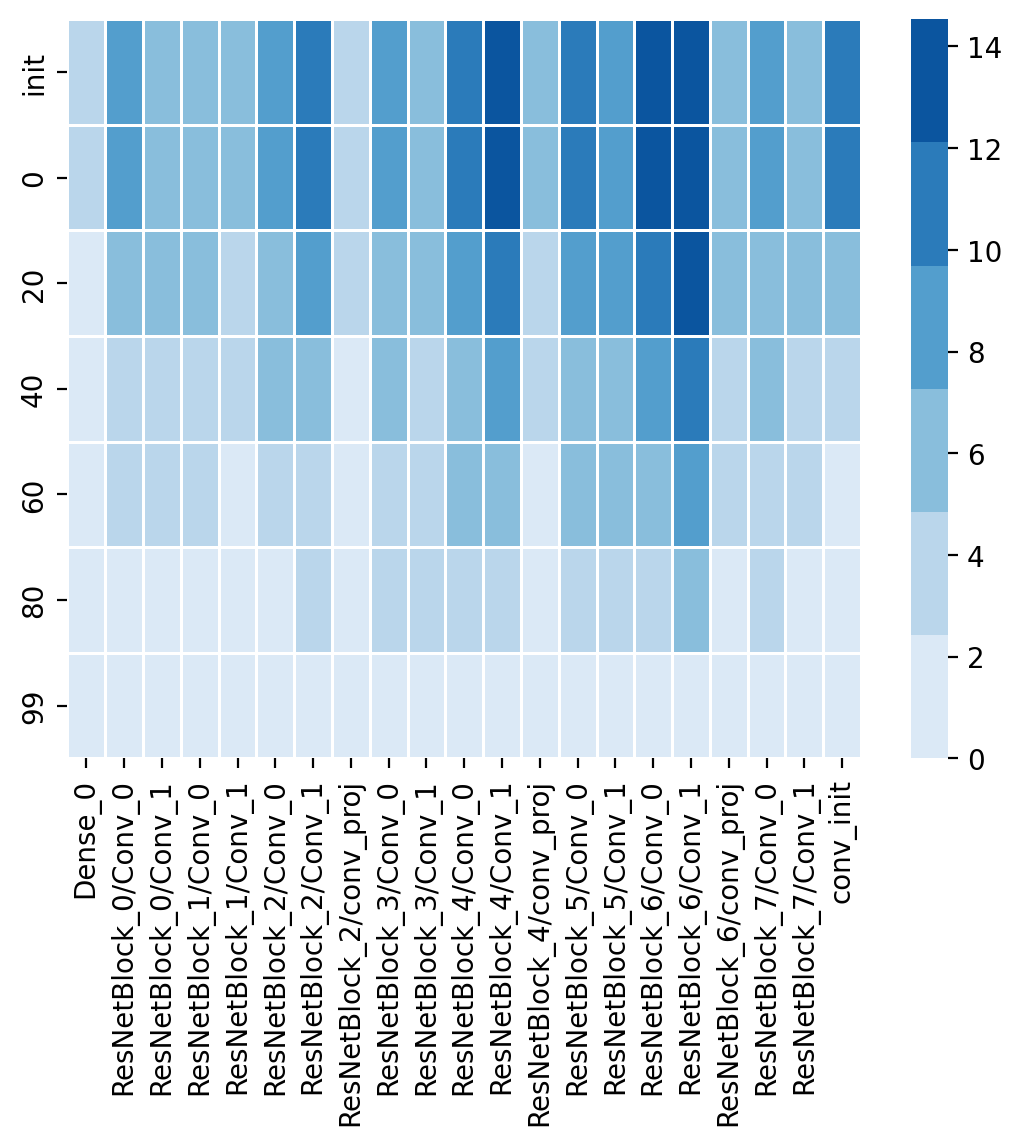

<Figure size 640x480 with 0 Axes>

In [33]:
def distance_from_init_network(checkpoint_fnames, converged_model_fname, metrics):
    """For each layer L and checkpoint C, compute the L2 distance of the trained
       parameters from those at the checkpoint C. Store the results in metrics.
    """
    assert 'l2_dist' in metrics,\
        "metrics should contain 'l2_dist' key."
    # Load checkpoint of converged model
    rng = jax.random.PRNGKey(seed)
    params = load_checkpoint(rng, converged_model_fname)

    # iterate through checkpoint fnames
    for epoch, checkpoint in checkpoint_fnames.items():
        params_epoch = load_checkpoint(rng, checkpoint)
        # iterate through layers
        metrics = reinit_layers(
            epoch, metrics, params, params_epoch)
        del params_epoch

    return metrics
metrics['l2_dist'] = {}
metrics = distance_from_init_network(checkpoint_fnames, converged_model_fname, metrics)
l2_dist = {'l2_dist' : metrics['l2_dist']}
plot_heatmaps(l2_dist, epochs, cmap=sns.color_palette("Blues"))

### Spearman Correlation

To conclude this exercise, you will compute the [Spearman rank correlation coeffiecient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the observed L2 distance $\|\theta^T_i - \theta^0_i\|_2$ for each layer, and the criticality values in `metrics` (train/test accuracy drop and loss increase).

In general, a correlation coefficient very close to $1$ denotes strong correlation, while a value close to $-1$ denotes anti-correlation, and finally values around $0$ express no strong correlation.

In [34]:
def spearman_rank(metrics, epoch):
    """Compute the Spearman order correlation between the observed
      L2 distances at @epoch and each metric in @metrics at @epoch

      ==============================
      TODO: Implementation required.
      ==============================

      Hint: for computing the Spearman rank, use `spearmanr` from `scipy`.
            For this assignment, we are not interested in p_values, as
            they are unreliable given the size of our observations.
    """
    from scipy.stats import spearmanr

    l2_distances = metrics['l2_dist'].get(epoch, [])

    l2_dist_correlation = {}

    for metric_name, metric_data in metrics.items():
        if metric_name == 'l2_dist':  # Skip the L2 distance itself
            continue

        metric_values = metric_data.get(epoch, [])
        if len(l2_distances) == len(metric_values) and len(l2_distances) > 0:
            correlation, _ = spearmanr(l2_distances, metric_values)
            l2_dist_correlation[metric_name] = correlation

    return l2_dist_correlation

test the `spearman_rank` function:

In [35]:
returned = spearman_rank({
    "test": {"init":[3,3,2,1]},
    "l2_dist": {"init": [1,2,3,4]}
    },
    'init')
expected = -0.9486832
np.testing.assert_almost_equal(returned['test'],
                               expected)


What conclusions can you draw from the computed Spearman correlations?

In [36]:
metric_cp={}
metric_cp['test']=metrics['test']
metric_cp['l2_dist']=metrics['l2_dist']
l2_dist_correlation_cp = spearman_rank(metric_cp, 'init')
print("Spearman correlations: {}".format(l2_dist_correlation_cp))
print(f"metrics: {metrics.keys()}")
print(f"metrics: {metrics['train'].keys()}")
print(f"metrics: {metrics['train']['loss'].keys()}")

Spearman correlations: {}
metrics: dict_keys(['train', 'test', 'l2_dist'])
metrics: dict_keys(['loss', 'accuracy'])
metrics: dict_keys(['init', '0', '20', '40', '60', '80', '99'])


In [37]:
l2_dist_correlation = spearman_rank(metrics, 'init')
print("Spearman correlations: {}".format(l2_dist_correlation))

Spearman correlations: {}


Finally, it is valuable for us to know how long did it take you to complete this practical?

## Optional: can non-critical layers be pruned?

**Note.** This task is only provided for fun in case the practical has piqued your interest. Therefore, it is not part of the mandatory assignment and will not lead to a bonus either.
As a optional task, repeat the criticality experiments on a VGG-11 network [Simonyan and Zisserman, 2015](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) trained on CIFAR-10, using the code from Part I.

More in detail, to complete the task you should:
1. Extend the code of Part I to define a VGG-11 network (called 'config A' in the paper).
2. Train VGG-11 on CIFAR-10, using data augmentation, no batch normalization, and on clean labels (no label noise). Save one checkpoint at initialization and for the trained model.
3. Repeat the layer criticality experiment on VGG-11. What pattern do you observe in the criticality of its layers?
4. Now go back to the code of Part I, and instantiate a new VGG model, by removing all non-critical layers. For this purpose, you can deem a layer non-critical if test accuracy drops at most by 0.1 when the layer is reset to its value at initialization.
5. Train the newly defined model, with data augmentation and no batch norm. Can you match the same performance that you obtained with VGG-11?

## References
* [Are All Layers Created Equal?](https://openreview.net/forum?id=ryg1P4Sh2E) - Zhang et al. ICML Workshop Deep Phenomena, 2019.
* [Very Deep Convolutional Networks for Large-Scale Visual Recognition](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) - Simonyan and Zisserman. ICRL 2015.
* [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html) - He et al. ICCV 2015.
* [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/cifar.html) - Krizhevsky and Hinton. 2009.

## Acknowledgements
* The code for operating on parameter dictionaries is adapted from the official [Flax Model Surgery tutorial](https://flax.readthedocs.io/en/latest/howtos/model_surgery.html).

## Changelog
| Version 	| Contribution      	| Author (Affiliation) 	                | Contact 	        |
|---------	|-------------------	|-----------------------------------    |---------	        |
| 1.0     	| First development 	| Matteo Gamba (KTH/EECS/RPL)       	|  ![contact address](figs/contact.png "Contact information") 	|